In [2]:
# importing pandas and numpy
import pandas as pd
import numpy as np

In [3]:
# creating database
np.random.seed(42)

# parameters
n_users = 5000
start_date = pd.to_datetime("2025-01-01")
end_date = pd.to_datetime("2025-03-31")

def random_date(start, end, n):
    return start + (end - start) * np.random.rand(n)

def assign_group(n):
    return np.random.choice(['control', 'treatment'], size=n, p=[0.5, 0.5])

def simulate_purchase(group, base_conversion=0.15, lift=0.05):
    if group == 'control':
        return np.random.rand() < base_conversion
    else:
        return np.random.rand() < (base_conversion + lift)

In [4]:
# gen user data
user_ids = np.arange(1, n_users + 1)
groups = assign_group(n_users)
entry_dates = random_date(start_date, end_date, n_users)
products = np.random.choice(['Budget App', 'Investment Tracker', 'Financial Course'], size=n_users)
prices = {'Budget App': 29.99, 'Investment Tracker': 49.99, 'Financial Course': 99.99}
price_original = [prices[p] for p in products]
price_adjustment = []

purchased = []
amount_spent = []

channels = np.random.choice(['organic', 'paid', 'referral'], size=n_users, p=[0.5, 0.4, 0.1])
locations = np.random.choice(['Germany', 'Austria', 'Switzerland'], size=n_users, p=[0.7, 0.15, 0.15])

for i in range(n_users):
    group = groups[i]
    original_price = price_original[i]

    if group == 'treatment':
        adjusted_price = round(original_price * 0.85, 2)  # 15% discount
    else:
        adjusted_price = original_price

    bought = simulate_purchase(group)
    spent = adjusted_price if bought else 0.0

    price_adjustment.append(adjusted_price)
    purchased.append(int(bought))
    amount_spent.append(round(spent, 2))

In [5]:
# creating DataFrame
df = pd.DataFrame({
    'user_id': user_ids,
    'entry_date': entry_dates,
    'group': groups,
    'product': products,
    'price_original': price_original,
    'price_applied': price_adjustment,
    'purchased': purchased,
    'amount_spent': amount_spent,
    'channel': channels,
    'location': locations
})

df.head()

,user_id,entry_date,group,product,price_original,price_applied,purchased,amount_spent,channel,location
0,1,2025-02-05 00:48:19.696725418,control,Financial Course,99.99,99.99,0,0.00,paid,Germany
1,2,2025-02-12 03:15:30.846330164,treatment,Investment Tracker,49.99,42.49,1,42.49,paid,Germany
2,3,2025-03-18 01:18:47.634767486,treatment,Budget App,29.99,25.49,0,0.00,organic,Germany
3,4,2025-01-31 06:14:57.727046146,treatment,Investment Tracker,49.99,42.49,0,0.00,paid,Germany
4,5,2025-03-19 09:34:18.216331672,control,Financial Course,99.99,99.99,1,99.99,paid,Germany


In [ ]:
# ANALYSIS
# importing packs
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [16]:
# conversion rates by group
conversion_rates = df.groupby('group')['purchased'].mean()
print(conversion_rates)

# average revenue per user
arpu = df.groupby('group')['amount_spent'].mean()
print(arpu)

group
control      0.1400
treatment    0.1992
Name: purchased, dtype: float64
group
control       8.614600
treatment    10.388408
Name: amount_spent, dtype: float64


In [17]:
# computing sample size
sample_sizes = df['group'].value_counts()
print(sample_sizes)

# testing period by selecting first and last entry date
test_period = (df['entry_date'].min(), df['entry_date'].max())
print(test_period)

control      2500
treatment    2500
Name: group, dtype: int64
(Timestamp('2025-01-01 00:06:46.217978589'), Timestamp('2025-03-30 22:56:35.106782609'))


In [23]:
# hypotesis tests
# conversion test
conversion_control = df[df['group'] == 'control']['purchased']
conversion_treatment = df[df['group'] == 'treatment']['purchased']
t_stat_conv, p_val_conv = ttest_ind(conversion_treatment, conversion_control)

# revenue test: ARPU (Mann-Whitney)
revenue_control = df[df['group'] == 'control']['amount_spent']
revenue_treatment = df[df['group'] == 'treatment']['amount_spent']
u_stat_arpu, p_val_arpu = mannwhitneyu(revenue_treatment, revenue_control)

# checking the balance of the model
balance_check = (
    df.groupby(['group', 'product', 'channel', 'location'])
      .size()
      .groupby(level=0)  # normalize by group (control/treatment)
      .apply(lambda x: x / x.sum())
      .unstack(fill_value=0)
)
balance_check.head(20)

location                               Austria  Germany  Switzerland
group     product            channel                                
control   Budget App         organic    0.0260   0.1224       0.0216
                             paid       0.0200   0.0764       0.0220
                             referral   0.0036   0.0220       0.0052
          Financial Course   organic    0.0252   0.1256       0.0228
                             paid       0.0220   0.0844       0.0252
                             referral   0.0024   0.0224       0.0052
          Investment Tracker organic    0.0216   0.1240       0.0248
                             paid       0.0272   0.0904       0.0228
                             referral   0.0056   0.0212       0.0080
treatment Budget App         organic    0.0276   0.1180       0.0244
                             paid       0.0208   0.0916       0.0184
                             referral   0.0032   0.0240       0.0040
          Financial Course   organic    0.0252   0.1128       0.0252
                             paid       0.0180   0.0992       0.0192
                             referral   0.0040   0.0260       0.0056
          Investment Tracker organic    0.0220   0.1160       0.0268
                             paid       0.0196   0.0924       0.0188
                             referral   0.0044   0.0268       0.0060

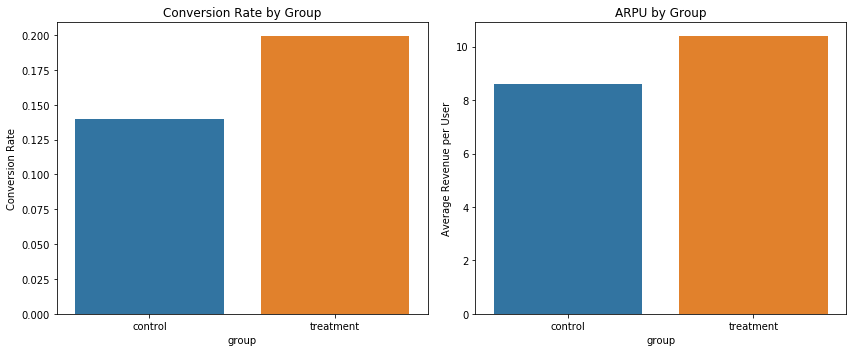

In [25]:
# DATA VISUALIZATION
plt.figure(figsize=(12, 5))

# conversion rate
plt.subplot(1, 2, 1)
sns.barplot(x=conversion_rates.index, y=conversion_rates.values)
plt.title('Conversion Rate by Group')
plt.ylabel('Conversion Rate')

# ARPU
plt.subplot(1, 2, 2)
sns.barplot(x=arpu.index, y=arpu.values)
plt.title('ARPU by Group')
plt.ylabel('Average Revenue per User')

plt.tight_layout()
plt.show()

In [28]:
# computing ci
ci_conversion = sm.stats.DescrStatsW(df['purchased'][df['group'] == 'treatment']).tconfint_mean()
ci_arpu = sm.stats.DescrStatsW(df['amount_spent'][df['group'] == 'treatment']).tconfint_mean()
print(ci_conversion)
print(ci_arpu)

(0.18353313657619819, 0.2148668634238018)
(9.461360743381872, 11.315455256618128)


In [29]:
# regression for robustness testing
model = smf.ols('amount_spent ~ group + C(channel) + C(location)', data=df).fit()
regression_summary = model.summary()

(
    conversion_rates,
    arpu,
    sample_sizes,
    test_period,
    (t_stat_conv, p_val_conv),
    (u_stat_arpu, p_val_arpu),
    balance_check.head(),
    ci_conversion,
    ci_arpu,
    regression_summary
)

(group
 control      0.1400
 treatment    0.1992
 Name: purchased, dtype: float64, group
 control       8.614600
 treatment    10.388408
 Name: amount_spent, dtype: float64, control      2500
 treatment    2500
 Name: group, dtype: int64, (Timestamp('2025-01-01 00:06:46.217978589'),
  Timestamp('2025-03-30 22:56:35.106782609')), (5.593560844560597,
  2.3429645582078826e-08), (3280238.0,
  3.262604298569375e-06), location                           Austria  Germany  Switzerland
 group   product          channel                                
 control Budget App       organic    0.0260   0.1224       0.0216
                          paid       0.0200   0.0764       0.0220
                          referral   0.0036   0.0220       0.0052
         Financial Course organic    0.0252   0.1256       0.0228
                          paid       0.0220   0.0844       0.0252, (0.18353313657619819,
  0.2148668634238018), (9.461360743381872,
  11.315455256618128), <class 'statsmodels.iolib.summary.